In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

# KNN Regression

### Warm-up 🥵

* How are weights implemented in K Nearest Neighbors?
  * By default in `sklearn` (aka the `'uniform'` option)?
  * When using the `'distance'` option in `sklearn`?
  
* What type of machine learning problem were we using KNN on up until now?

## Data Import and General EDA 🚗

We'll be looking at the auto MPG dataset from UCI.  Which can be found [here](https://archive.ics.uci.edu/ml/datasets/auto+mpg).  From the description we see:

1. mpg: continuous
2. cylinders: multi-valued discrete
3. displacement: continuous
4. horsepower: continuous
5. weight: continuous
6. acceleration: continuous
7. model year: multi-valued discrete
8. origin: multi-valued discrete
9. car name: string (unique for each instance)

Our target variable will be `mpg`.

In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

data_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data-original"
names = [
    "mpg",
    "cylinders",
    "displacement",
    "horsepower",
    "weight",
    "acceleration",
    "year",
    "origin",
    "model",
]

# '\s+' means "more than 1 space" you can download the
# data from the data_url to inspect the data and see why this makes sense
auto = pd.read_csv(data_url, sep="\s+", names=names)

<IPython.core.display.Javascript object>

Do some *really* general eda.  i.e just stuff like shape/head/info/describe

In [3]:
auto.shape

(406, 9)

<IPython.core.display.Javascript object>

In [4]:
auto.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 406 entries, 0 to 405
Data columns (total 9 columns):
mpg             398 non-null float64
cylinders       406 non-null float64
displacement    406 non-null float64
horsepower      400 non-null float64
weight          406 non-null float64
acceleration    406 non-null float64
year            406 non-null float64
origin          406 non-null float64
model           406 non-null object
dtypes: float64(8), object(1)
memory usage: 28.7+ KB


<IPython.core.display.Javascript object>

In [5]:
auto.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,model
0,18.0,8.0,307.0,130.0,3504.0,12.0,70.0,1.0,chevrolet chevelle malibu
1,15.0,8.0,350.0,165.0,3693.0,11.5,70.0,1.0,buick skylark 320
2,18.0,8.0,318.0,150.0,3436.0,11.0,70.0,1.0,plymouth satellite
3,16.0,8.0,304.0,150.0,3433.0,12.0,70.0,1.0,amc rebel sst
4,17.0,8.0,302.0,140.0,3449.0,10.5,70.0,1.0,ford torino


<IPython.core.display.Javascript object>

In [6]:
auto.isna().mean().sort_values(ascending=False).head()

mpg           0.019704
horsepower    0.014778
model         0.000000
origin        0.000000
year          0.000000
dtype: float64

<IPython.core.display.Javascript object>

Display rows with any NAs in them.

In [7]:
# Find rows with any `np.nan`s
na_filter = auto.isna().any(axis=1)

# Filter to those
auto[na_filter]

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,model
10,NaN,4.0,133.0,115.0,3090.0,17.5,70.0,2.0,citroen ds-21 pallas
11,NaN,8.0,350.0,165.0,4142.0,11.5,70.0,1.0,chevrolet chevelle concours (sw)
12,NaN,8.0,351.0,153.0,4034.0,11.0,70.0,1.0,ford torino (sw)
13,NaN,8.0,383.0,175.0,4166.0,10.5,70.0,1.0,plymouth satellite (sw)
14,NaN,8.0,360.0,175.0,3850.0,11.0,70.0,1.0,amc rebel sst (sw)
17,NaN,8.0,302.0,140.0,3353.0,8.0,70.0,1.0,ford mustang boss 302
38,25.0,4.0,98.0,NaN,2046.0,19.0,71.0,1.0,ford pinto
39,NaN,4.0,97.0,48.0,1978.0,20.0,71.0,2.0,volkswagen super beetle 117
133,21.0,6.0,200.0,NaN,2875.0,17.0,74.0,1.0,ford maverick
337,40.9,4.0,85.0,NaN,1835.0,17.3,80.0,2.0,renault lecar deluxe


<IPython.core.display.Javascript object>

## Data Cleaning and Feature Engineering

### Handling NAs

Since our target variable is `mpg` we probably don't want to do any imputation strategy on it.  We should drop NAs in the target unless we have some domain expertise that tells us otherwise.

The `horsepower` column is responsible for the rest of the NAs.  In practice, we might look up this info somehow, but that would probably take too much time for this demo.

So how do you want to handle these? by dropping? with imputation?  If imputing, what should we impute?

In [8]:
auto = auto.dropna()

<IPython.core.display.Javascript object>

### Handling Categorical Variables

* From the description of the columns above, we can see that `origin` should is a 'discrete' value.
* The `model` column is also a categorical variable
* You can also see that `year` is 'discrete' from the description, but in practice we'll treat year variables as ordinal, so we don't need to make any changes.

Show the value counts for each of our categorical columns (don't include year).

In [9]:
# TODO: If poor performance, revaluate cyl as cat rather than num
# TODO: Also investigate cyl == 3 and cyl == 5

<IPython.core.display.Javascript object>

In [10]:
# MVP: minimal viable product
# rapid prototyping
# agile methodology (google wrt data science)

<IPython.core.display.Javascript object>

In [11]:
cat_cols = ["origin", "model"]


<IPython.core.display.Javascript object>

In [12]:
auto["origin"].value_counts()

1.0    245
3.0     79
2.0     68
Name: origin, dtype: int64

<IPython.core.display.Javascript object>

In [13]:
auto["model"].value_counts()

toyota corolla               5
amc matador                  5
ford pinto                   5
amc hornet                   4
amc gremlin                  4
                            ..
ford fairmont 4              1
vw pickup                    1
toyota celica gt liftback    1
volkswagen model 111         1
honda civic (auto)           1
Name: model, Length: 301, dtype: int64

<IPython.core.display.Javascript object>

For origin, this is a pretty easy decision, let's one-hot encode and move on.  We're deciding to one-hot encode instead of leaving it as oridinal, because we have no reason to believe that the origin is ordinal.

The model category is a little trickier... Most of the model categories have only 1 value (we have 305 categories for our 406 rows).  This level of variation wouldn't be too useful.  What is a feature we could engineer from this column though?

In [14]:
auto["make"] = auto["model"].str.split(" ").str[0]

# TODO: fix typos and multiple names for companies
# ie {'toyouta': 'toyota', 'vw': 'volkswagen'}
make_counts = auto["make"].value_counts()
make_counts.head(10)

ford          48
chevrolet     43
plymouth      31
dodge         28
amc           27
toyota        25
datsun        23
buick         17
pontiac       16
volkswagen    15
Name: make, dtype: int64

<IPython.core.display.Javascript object>

In [15]:
keep_top_perc = 75

thresh = np.percentile(make_counts, keep_top_perc)
keep_makes = make_counts[make_counts >= thresh].index
keep_makes

Index(['ford', 'chevrolet', 'plymouth', 'dodge', 'amc', 'toyota', 'datsun',
       'buick', 'pontiac', 'volkswagen'],
      dtype='object')

<IPython.core.display.Javascript object>

In [16]:
auto.loc[~auto["make"].isin(keep_makes), "make"] = "other"

<IPython.core.display.Javascript object>

In [17]:
auto["make"].value_counts()

other         119
ford           48
chevrolet      43
plymouth       31
dodge          28
amc            27
toyota         25
datsun         23
buick          17
pontiac        16
volkswagen     15
Name: make, dtype: int64

<IPython.core.display.Javascript object>

## Modeling

Perform a train/test split with 20% of the data in the test set.

In [18]:
X = auto.drop(columns=["mpg", "model"])
y = auto["mpg"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

<IPython.core.display.Javascript object>

We're going to build... a modeling pipeline for KNN.

In [19]:
cat_cols = ["origin", "make"]
drop_cats = [1, "other"]

# The rest are numeric
num_cols = [c for c in X if c not in cat_cols]

<IPython.core.display.Javascript object>

In [40]:
# Preprocessing aka column transforming
preprocessing = ColumnTransformer(
    [
        # ('name_of_step', PreProcessingObject(), [list_of_cols])
        ("encode_cats", OneHotEncoder(drop=drop_cats), cat_cols),
        ("scale_nums", StandardScaler(), num_cols),
    ]
)

# Modeling pipeline (which will include the preprocessing pipeline)
pipeline = Pipeline(
    [
        ("preprocess", preprocessing),
        ("feat_select", SelectKBest(f_regression)),
        ("regress", KNeighborsRegressor()),
#         ("regress", LinearRegression()),
    ]
)

grid = {
    "feat_select__k": range(1, X_train.shape[1] + 1),
    "regress__n_neighbors": range(1, 16),
    "regress__weights": ["uniform", "distance"],
}

pipeline_cv = GridSearchCV(pipeline, grid, verbose=1)
pipeline_cv.fit(X_train, y_train)

pipeline_cv.best_params_

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1200 out of 1200 | elapsed:   13.9s finished


{'feat_select__k': 6,
 'regress__n_neighbors': 4,
 'regress__weights': 'distance'}

<IPython.core.display.Javascript object>

In [41]:
train_score = pipeline_cv.score(X_train, y_train)
test_score = pipeline_cv.score(X_test, y_test)

print(f"train_score: {train_score}")
print(f"test_score: {test_score}")

train_score: 0.9990886177411457
test_score: 0.8785489704893922


<IPython.core.display.Javascript object>

In [42]:
y_pred = pipeline_cv.predict(X_test)

errors = y_pred - y_test
abs_errors = errors.abs()
mae = abs_errors.mean()
mae

1.760113839937034

<IPython.core.display.Javascript object>

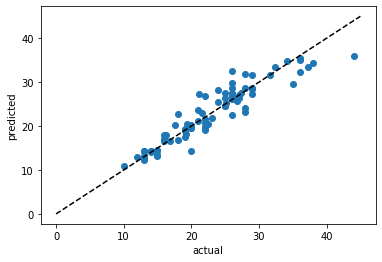

<IPython.core.display.Javascript object>

In [43]:
plt.scatter(y_test, y_pred)
plt.plot([0, 45], [0, 45], ls="--", c="black")
plt.xlabel("actual")
plt.ylabel("predicted")
plt.show()

Compare to linear regression